<a href="https://colab.research.google.com/github/EmilyWarnerSoderholm/ihMT_MRF/blob/main/Emily%2C_ihMT_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

directory = '/content/drive/My Drive/group_project/MT_training_E/'  # we define the directory of the data

Mounted at /content/drive


In [ ]:
# Defining network architecture
class ihMT_nn(nn.Module):
    def __init__(self):
        super(ihMT_nn, self).__init__()
        # First layer takes signal as input
        self.input_layer = nn.Linear(1200,300)
        # Define hidden layer block
        self.hidden_layer = nn.Linear(300,300)
        self.output_layer = nn.Linear(300,3)
    def forward(self, x):
        x = x.view(-1, 1200)
        x = torch.tanh(self.input_layer(x))
        x = torch.tanh(self.hidden_layer(x))
        x = torch.sigmoid(self.output_layer(x))

        return x
        

In [ ]:
# Define training routine
def train(epoch, train_loss_vec, log_interval=200):
    # Set model to training mode
    net.train()
    train_loss = 0
    # Loop over each batch from training set
    for batch_number, (signal, label) in enumerate(train_loader):
        # Add noise to the signal - added here so that the network sees each
        # signal with different noise signatures so that the network becomes
        # more robust to them
        mu, sigma = 0, 0.01 * max_signals
        noise = torch.from_numpy(np.random.normal(mu, sigma, (signal.shape[0], signal.shape[1])))
        signal += noise

        signal = signal.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = net(signal)
        loss = loss_func(output, label)
        train_loss += loss
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_loss_vec.append(train_loss)
    print('\nTraining set: Average loss: {:.8f}'.format(train_loss))
    

In [ ]:
# Define validation routine
def validate():
    # Set the model to evaluate mode.
    net.eval()
    val_loss = 0
    noisy_val_loss = 0
    # Loop over each batch in validation set
    for signal, label in val_loader:
        # Add noise to validation signals too.
        mu, sigma = 0, 0.01 * max_signals
        noise = torch.from_numpy(np.random.normal(mu, sigma, (signal.shape[0], signal.shape[1])))
        noisy_signal = signal + noise
        noisy_signal = noisy_signal.type(torch.float32)

        signal = signal.to(device)
        noisy_signal = noisy_signal.to(device)
        label = label.to(device)
        with torch.no_grad():
            output = net(signal)
            noisy_output = net(noisy_signal)
        val_loss += loss_func(output, label).data.item()
        noisy_val_loss += loss_func(noisy_output, label).data.item()

    val_loss /= len(val_loader)
    noisy_val_loss /= len(val_loader)
    
    print('\nValidation set: Average loss: {:.8f}'.format(
        val_loss))
    print('\nNoisy Validation set: Average loss: {:.8f}'.format(
        noisy_val_loss))
    return val_loss, noisy_val_loss
    

In [ ]:
# Define testing routine
def test():
    # Set the model to evaluate mode.
    preds = np.array([[0, 0, 0]])
    noisy_preds = np.array([[0, 0, 0]])
    best_net.eval()
    best_noisy_net.eval()
    for signal, _ in test_loader:
        mu, sigma = 0, 0.01 * max_signals
        noise = torch.from_numpy(np.random.normal(mu, sigma, (signal.shape[0], signal.shape[1])))
        noisy_signal = signal + noise
        noisy_signal = noisy_signal.type(torch.float32)

        signal = signal.to(device)
        noisy_signal = noisy_signal.to(device)
        with torch.no_grad():
            output = best_net(signal).cpu().numpy()
            noisy_output = best_noisy_net(noisy_signal).cpu().numpy()
        preds = np.concatenate((preds, output), axis=0)
        noisy_preds = np.concatenate((noisy_preds, noisy_output), axis=0)

    return np.delete(preds, (0), axis=0), np.delete(noisy_preds, (0), axis=0)
    

In [ ]:
# Full training + validation routine
def train_network(epochs, best_net, best_noisy_net):
    train_vec = []
    val_vec = []
    noisy_val_vec = []
    best_loss = 1e100
    best_noisy_loss = 1e100
    for epoch in range(1, epochs + 1):
        train(epoch, train_vec)
        val_loss, noisy_val_loss = validate()
        if val_loss < best_loss:
            best_loss = val_loss
            best_net = net
            best_epoch = epoch
        if noisy_val_loss < best_noisy_loss:
            best_noisy_loss = noisy_val_loss
            best_noisy_net = net
            best_noisy_epoch = epoch
        # we store this for graphing later
        val_vec.append(val_loss)
        noisy_val_vec.append(noisy_val_loss)

    # Save model so no need to train again
    torch.save(best_net, directory + 'MT_nn_dict_one.pt')
    torch.save(best_noisy_net, directory + 'MT_nn_noisy_dict_one.pt')
    print('Best epoch = {}'.format(best_epoch))
    print('Best validation loss = {}'.format(best_loss))
    print('Best noisy epoch = {}'.format(best_noisy_epoch))
    print('Best noisy validation loss = {}'.format(best_noisy_loss))

    # Plot validation loss and accuracy as function of epoch
    fig1 = plt.figure(figsize=(8, 8))
    plt.plot(np.arange(1, epochs + 1), train_vec, label='Training')
    plt.plot(np.arange(1, epochs + 1), val_vec, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    #fig1.savefig(directory + 'loss_ep_' + str(best_epoch) + 'MT_dict_one_pres.png')
    fig1.savefig(directory + 'loss_ep_MT_dict_one_pres.png')

    # Plot validation loss and accuracy as function of epoch
    fig2 = plt.figure(figsize=(8, 8))
    plt.plot(np.arange(1, epochs + 1), train_vec, label='Training')
    plt.plot(np.arange(1, epochs + 1), noisy_val_vec, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    #fig2.savefig(directory + 'loss_ep_' + str(best_epoch) + 'MT_noisy_dict_one_pres.png')
    fig2.savefig(directory + 'loss_ep_MT_noisy_dict_one_pres.png')

    return best_epoch, best_noisy_epoch
    

In [ ]:
# Now to setup the data loaders
random.seed(42)
net = ihMT_nn()
net = net.to(device)
best_net = net
best_noisy_net = net

# Load data
dataMss = sio.loadmat(directory + 'Mss_AllSigsT1fM0sT1d.mat')
dataVP = sio.loadmat(directory + 'VP_AllSigsT1fM0sT1d.mat')
signal_data = dataMss['Mss_AllSigs'] [1600:,:]
n_samples, n_t = signal_data.shape
label_data = dataVP['VP_AllSigs'][1600:,[1, 4, 6]]

# Normalise data and labels
signals = np.absolute(signal_data)
labels = label_data
signal_means = np.mean(signals, axis=1)
signals = signals / signal_means[:, None]
max_signals = np.max(signals)
max_labels = max_labels = np.max(labels, axis=0)
labels = labels / max_labels[None,:]



# generate test (10%), validation (10%) and train data (80%) - shuffle to give random selection
tenpc = int(np.floor(n_samples/10))
ids = list(np.arange(n_samples))
random.shuffle(ids)
test_ids = ids[-tenpc:]
del ids[-tenpc:]
vali_ids = ids[-tenpc:]
del ids[-tenpc:]
train_ids = ids

train_signals = torch.from_numpy(signals[train_ids, :]).type(torch.float32)
train_labels = torch.from_numpy(labels[train_ids, :]).type(torch.float32)
vali_signals = torch.from_numpy(signals[vali_ids, :]).type(torch.float32)
vali_labels = torch.from_numpy(labels[vali_ids, :]).type(torch.float32)
test_signals = torch.from_numpy(signals[test_ids, :]).type(torch.float32)
test_labels = torch.from_numpy(labels[test_ids, :]).type(torch.float32)

# Load datasets into DataLoader objects
train_dataset = torch.utils.data.TensorDataset(train_signals, train_labels)
vali_dataset = torch.utils.data.TensorDataset(vali_signals, vali_labels)
test_dataset = torch.utils.data.TensorDataset(test_signals, test_labels)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    vali_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False)


In [ ]:
# Define loss function and optimizer
loss_func = nn.MSELoss()
loss_func = loss_func.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)



Training set: Average loss: 0.04229318

Validation set: Average loss: 0.02520747

Noisy Validation set: Average loss: 0.02523925

Training set: Average loss: 0.01526379

Validation set: Average loss: 0.01687775

Noisy Validation set: Average loss: 0.01692822

Training set: Average loss: 0.01041805

Validation set: Average loss: 0.00570505

Noisy Validation set: Average loss: 0.00580063

Training set: Average loss: 0.00861757

Validation set: Average loss: 0.00553964

Noisy Validation set: Average loss: 0.00574551

Training set: Average loss: 0.00696107

Validation set: Average loss: 0.00559934

Noisy Validation set: Average loss: 0.00578316

Training set: Average loss: 0.00726705

Validation set: Average loss: 0.00851581

Noisy Validation set: Average loss: 0.00866062

Training set: Average loss: 0.00626720

Validation set: Average loss: 0.00552304

Noisy Validation set: Average loss: 0.00569377

Training set: Average loss: 0.00814174

Validation set: Average loss: 0.01334068

Noisy V

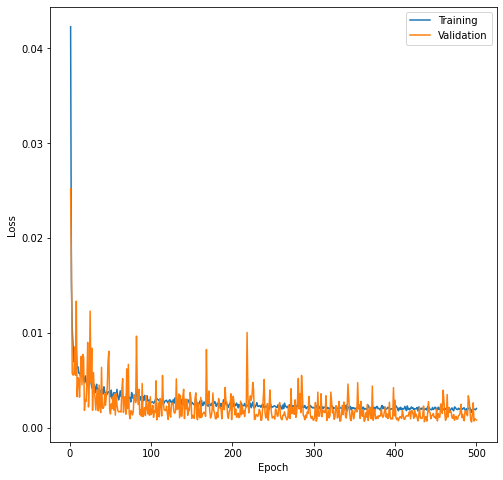

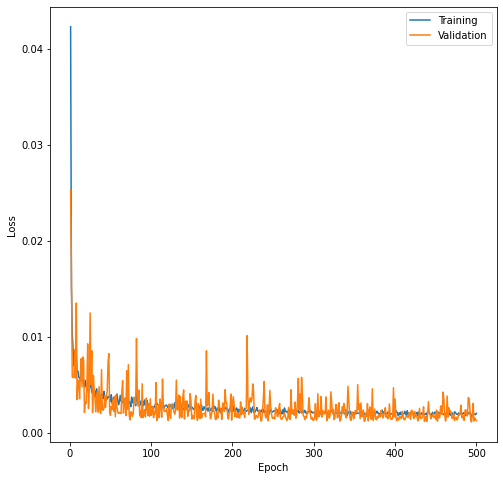

In [ ]:
# Train the network
epochs = 500
train_vec, val_vec = [], [] 
best_epoch, best_noisy_epoch = train_network(epochs, best_net, best_noisy_net)


Testing network...
0.42750096321105957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


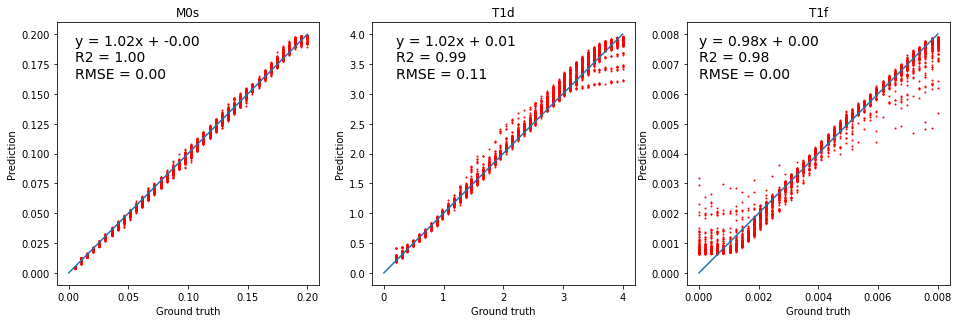

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


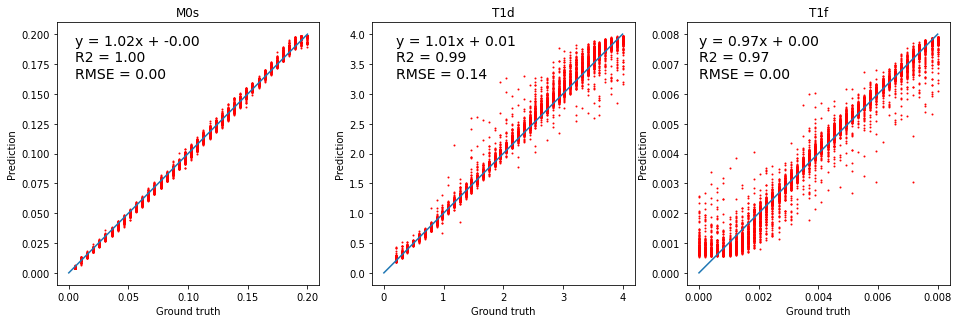

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import time

# Test network performance
print('Testing network...')
t0 = time.time()
test_pred, noisy_test_pred = test()
t1 = time.time()
matching_time = t1-t0
print(matching_time)

# Scale pred labels and test labels
test_pred = test_pred * max_labels
noisy_test_pred = noisy_test_pred * max_labels 
# Scale back test labels
gt_labels = test_labels * max_labels
# Linear fit to noiseless data
r2_M0s, r2_T1d, r2_T1f = r2_score(gt_labels[:,0], test_pred[:,0]), r2_score(gt_labels[:,1], test_pred[:,1]),r2_score(gt_labels[:,2], test_pred[:,2])
rmse_M0s, rmse_T1d, rmse_T1f = np.sqrt(mean_squared_error(gt_labels[:,0], test_pred[:,0])), np.sqrt(mean_squared_error(gt_labels[:,1], test_pred[:,1])), np.sqrt(mean_squared_error(gt_labels[:,2], test_pred[:,2]))
x_M0s = np.linspace(torch.min(gt_labels[:,0]), torch.max(gt_labels[:,0]), 10)
x_T1d  = np.linspace(torch.min(gt_labels[:,1]), torch.max(gt_labels[:,1]), 10)
x_T1f = np.linspace(torch.min(gt_labels[:,2]), torch.max(gt_labels[:,2]), 10)

m_M0s, b_M0s = np.polyfit(gt_labels[:,0], test_pred[:,0], 1)
fit_M0s = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(m_M0s, b_M0s, r2_M0s, rmse_M0s)

m_T1d, b_T1d = np.polyfit(gt_labels[:,1], test_pred[:,1], 1)
fit_T1d = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(m_T1d, b_T1d, r2_T1d, rmse_T1d)

m_T1f, b_T1f = np.polyfit(gt_labels[:,2], test_pred[:,2], 1)
fit_T1f = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(m_T1f, b_T1f, r2_T1f, rmse_T1f)

y_M0s, y_T1d, y_T1f = m_M0s * x_M0s + b_M0s, m_T1d * x_T1d + b_T1d, m_T1f * x_T1f + b_T1f

# Linear fit to noisy data
noisy_r2_M0s, noisy_r2_T1d, noisy_r2_T1f = r2_score(gt_labels[:,0], noisy_test_pred[:,0]), r2_score(gt_labels[:,1], noisy_test_pred[:,1]), r2_score(gt_labels[:,2], noisy_test_pred[:,2])
noisy_rmse_M0s, noisy_rmse_T1d, noisy_rmse_T1f = np.sqrt(mean_squared_error(gt_labels[:,0], noisy_test_pred[:,0])), np.sqrt(mean_squared_error(gt_labels[:,1], noisy_test_pred[:,1])), np.sqrt(mean_squared_error(gt_labels[:,2], noisy_test_pred[:,2]))
noisy_x_M0s = np.linspace(torch.min(gt_labels[:,0]), torch.max(gt_labels[:,0]), 10)
noisy_x_T1d = np.linspace(torch.min(gt_labels[:,1]), torch.max(gt_labels[:,1]), 10)
noisy_x_T1f = np.linspace(torch.min(gt_labels[:,2]), torch.max(gt_labels[:,2]), 10)

noisy_m_M0s, noisy_b_M0s = np.polyfit(gt_labels[:,0], noisy_test_pred[:,0], 1)
noisy_fit_M0s = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(noisy_m_M0s, noisy_b_M0s, noisy_r2_M0s, noisy_rmse_M0s)

noisy_m_T1d, noisy_b_T1d = np.polyfit(gt_labels[:,1], noisy_test_pred[:,1], 1)
noisy_fit_T1d = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(noisy_m_T1d, noisy_b_T1d, noisy_r2_T1d, noisy_rmse_T1d)

noisy_m_T1f, noisy_b_T1f = np.polyfit(gt_labels[:,2], noisy_test_pred[:,2], 1)
noisy_fit_T1f = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(noisy_m_T1f, noisy_b_T1f, noisy_r2_T1f, noisy_rmse_T1f)


fig3 = plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.plot([0, max_labels[0]], [0, max_labels[0]], '-')  # identity line
plt.scatter(gt_labels[:,0], test_pred[:,0], color='r', s=1)
plt.title('M0s')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.text(min(gt_labels[:,0]), max(gt_labels[:,0]), fit_M0s, fontsize=14, verticalalignment='top')

plt.subplot(132)
plt.plot([0, max_labels[1]], [0, max_labels[1]], '-')  # identity line
plt.scatter(gt_labels[:,1], test_pred[:,1], color='r', s=1)
plt.title('T1d')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.text(min(gt_labels[:,1]), max(gt_labels[:,1]), fit_T1d, fontsize=14, verticalalignment='top')

plt.subplot(133)
plt.plot([0, max_labels[2]], [0, max_labels[2]], '-')  # identity line
plt.scatter(gt_labels[:,2], test_pred[:,2], color='r', s=1)
plt.title('T1f')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.text(min(gt_labels[:,2]), max(gt_labels[:,2]), fit_T1f, fontsize=14, verticalalignment='top')

plt.subplot(133)
plt.show()
#fig3.savefig(directory + 'test_ep_' + str(best_epoch) + 'MT_vali_dict_one_pres.png')
fig3.savefig(directory + 'test_ep_MT_vali_dict_one_pres.png')

fig4 = plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.plot([0, max_labels[0]], [0, max_labels[0]], '-')  # identity line
plt.scatter(gt_labels[:,0], noisy_test_pred[:,0], color='r', s=1)
plt.title('M0s')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.text(min(gt_labels[:,0]), max(gt_labels[:,0]), noisy_fit_M0s, fontsize=14, verticalalignment='top')

plt.subplot(132)
plt.plot([0, max_labels[1]], [0, max_labels[1]], '-')  # identity line
plt.scatter(gt_labels[:,1], noisy_test_pred[:,1], color='r', s=1)
plt.title('T1d')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.text(min(gt_labels[:,1]), max(gt_labels[:,1]), noisy_fit_T1d, fontsize=14, verticalalignment='top')

plt.subplot(133)
plt.plot([0, max_labels[2]], [0, max_labels[2]], '-')  # identity line
plt.scatter(gt_labels[:,2], noisy_test_pred[:,2], color='r', s=1)
plt.title('T1f')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.text(min(gt_labels[:,2]), max(gt_labels[:,2]), noisy_fit_T1f, fontsize=14, verticalalignment='top')

plt.subplot(133)
plt.show()
#fig4.savefig(directory + 'test_ep_' + str(best_noisy_epoch) + 'MT_noisy_vali_dict_one_pres.png')
fig4.savefig(directory + 'test_ep_MT_noisy_vali_dict_one_pres.png')
